In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HF_HOME"]="/media/data/schwager/huggingface"

In [2]:
from echo.eval.evaluate import evaluate
from pathlib import Path
import pandas as pd
import gc
import torch
import tqdm
import json

/opt/anaconda/envs/echo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
outputs_dir = Path("../../outputs")

In [4]:
history_base_model = json.load(open(outputs_dir / "Llama-3.1-8B-Instruct/predictions_20251126_143753.json"))
bio_base_model = json.load(open(outputs_dir / "Llama-3.1-8B-Instruct/predictions_20251126_140959.json"))

history_ft_model = json.load(open(outputs_dir / "Llama-3.1-8B-Instruct-eng-history/predictions_20251126_142911.json"))
bio_ft_model = json.load(open(outputs_dir / "Llama-3.1-8B-Instruct-eng-bio/predictions_20251126_140342.json"))

models = [history_base_model, bio_base_model, history_ft_model, bio_ft_model]
model_names = ["history_base_model", "bio_base_model", "history_ft_model", "bio_ft_model"]

In [5]:
results_df = pd.DataFrame()

In [ ]:
results_df = pd.DataFrame()
for i in range(3, 30):
    indexes_with_history_lenth_i = [j for j, x in enumerate(history_base_model["generations"]) if (len(x['prompt'])-2) / 2 == i]
    print(i)
    for model, model_name in zip(models, model_names):
        model = model.copy()
        model.update({"generations": [model["generations"][j] for j in indexes_with_history_lenth_i]})
        
        temp_path = f"temp.json"
        with open(temp_path, "w") as f:
            json.dump(model, f, indent=2)
        
        metrics = evaluate(temp_path, save_metrics=False)
        
        # Flatten nested metrics
        flat = {
            'bleu': metrics['bleu']['bleu'],
            'bleu_precision_1': metrics['bleu']['precisions'][0],
            'bleu_precision_2': metrics['bleu']['precisions'][1],
            'bleu_precision_3': metrics['bleu']['precisions'][2],
            'bleu_precision_4': metrics['bleu']['precisions'][3],
            'brevity_penalty': metrics['bleu']['brevity_penalty'],
            'length_ratio': metrics['bleu']['length_ratio'],
            'rouge1': metrics['rouge']['rouge1'],
            'rouge2': metrics['rouge']['rouge2'],
            'rougeL': metrics['rouge']['rougeL'],
            'rougeLsum': metrics['rouge']['rougeLsum'],
            'qwen3_embedding_distance': metrics.get('qwen3_embedding_distance'),
            'gemma_embedding_distance': metrics.get('gemma_embedding_distance'),
            'luxembourgish_embedding_distance': metrics.get('luxembourgish_embedding_distance'),
            'model': model_name,
            'history_length': i,
            'num_samples': len(model["generations"])
        }
        results_df = pd.concat([results_df, pd.DataFrame([flat])], ignore_index=True)
        
        os.remove(temp_path)

3


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


4


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


5


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


6


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


7


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


8


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


9


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


10


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


11


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


12


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


13


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


14


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


15


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


16


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


17


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


18


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


19


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


20


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


21


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


22


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


23


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


In [ ]:
# Save Dataframe
results_df.to_csv("as1.csv", index=False)

In [ ]:
results_df["qwen3_embedding_distance"] = results_df["qwen3_embedding_distance"].apply(lambda x: x["mean_distance"])
results_df["gemma_embedding_distance"] = results_df["gemma_embedding_distance"].apply(lambda x: x["mean_distance"])
results_df["luxembourgish_embedding_distance"] = results_df["luxembourgish_embedding_distance"].apply(lambda x: x["mean_distance"])

TypeError: 'float' object is not subscriptable

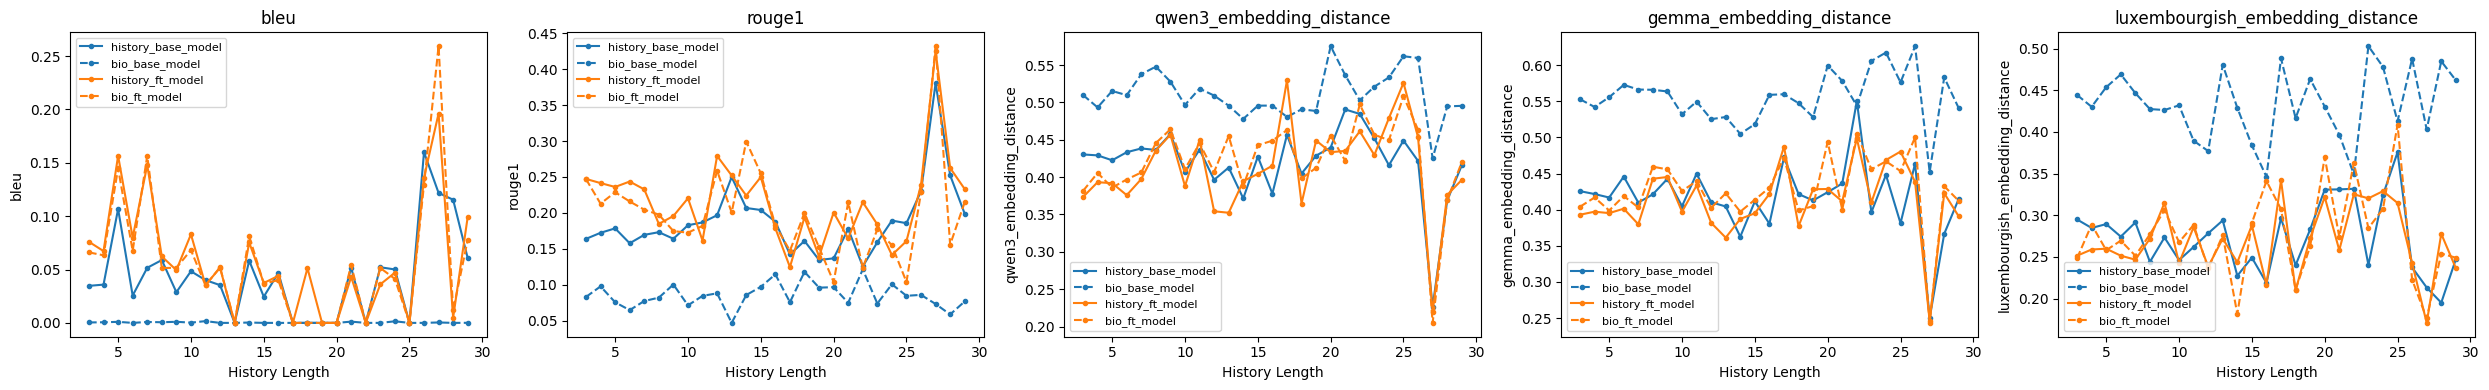

In [ ]:
import matplotlib.pyplot as plt

# Identify metric columns (exclude metadata)
metric_cols = ["bleu", "rouge1", "qwen3_embedding_distance", "gemma_embedding_distance", "luxembourgish_embedding_distance"]

# Define styling
colors = {"base": "tab:blue", "ft": "tab:orange"}
linestyles = {"history": "-", "bio": "--"}

fig, axes = plt.subplots(1, len(metric_cols), figsize=(5 * len(metric_cols), 4), sharey=False)
if len(metric_cols) == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_cols):
    for model_name in model_names:
        # Parse model name for styling
        mode = "ft" if "ft" in model_name else "base"
        domain = "history" if "history" in model_name else "bio"
        
        subset = results_df[results_df["model"] == model_name].sort_values("history_length")
        ax.plot(
            subset["history_length"],
            subset[metric],
            label=model_name,
            color=colors[mode],
            linestyle=linestyles[domain],
            marker="o",
            markersize=3
        )
    ax.set_xlabel("History Length")
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

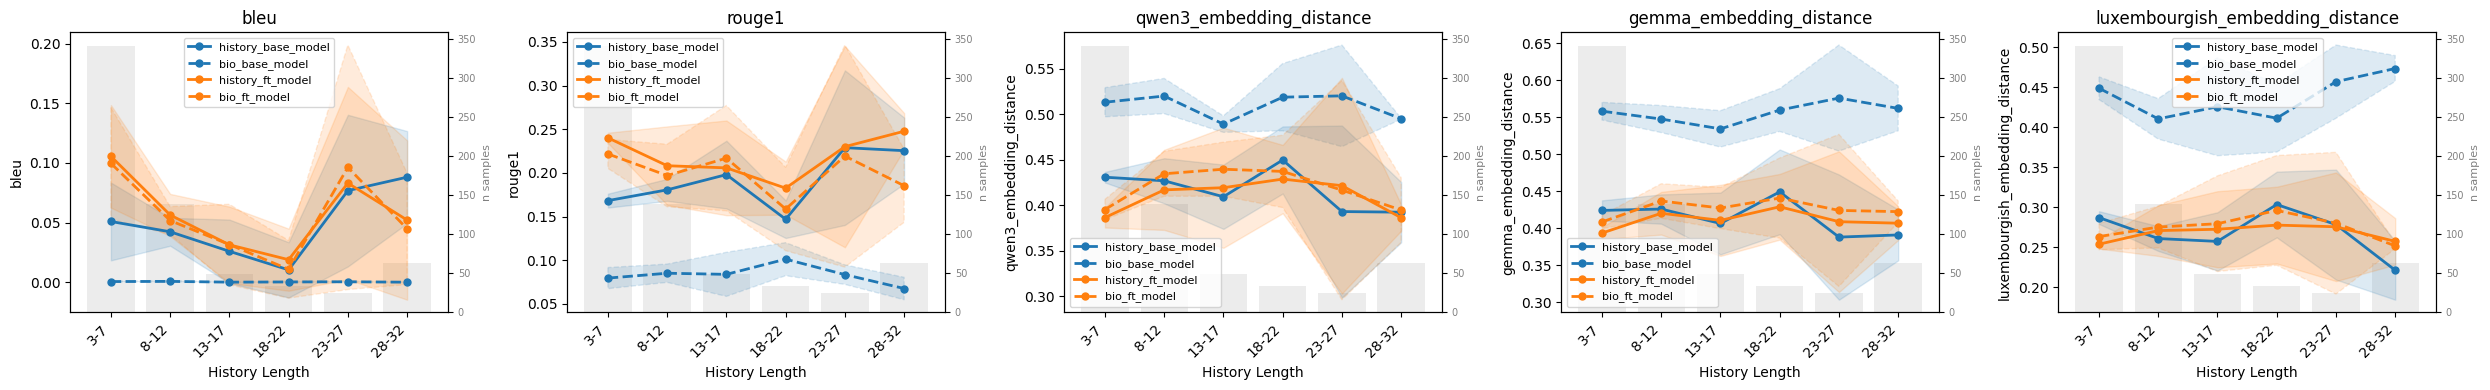

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metric_cols = ["bleu", "rouge1", "qwen3_embedding_distance", "gemma_embedding_distance", "luxembourgish_embedding_distance"]

colors = {"base": "tab:blue", "ft": "tab:orange"}
linestyles = {"history": "-", "bio": "--"}

# Create bins (3-7, 8-12, 13-17, ...)
bins = list(range(3, 35, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

results_df["history_bin"] = pd.cut(
    results_df["history_length"], 
    bins=bins, 
    labels=labels, 
    right=False
)

# Aggregate: mean and std for metrics, sum for num_samples
agg_mean = {col: "mean" for col in metric_cols}
agg_mean["num_samples"] = "sum"
agg_std = {col: "std" for col in metric_cols}

results_mean = results_df.groupby(["model", "history_bin"], observed=True).agg(agg_mean).reset_index()
results_std = results_df.groupby(["model", "history_bin"], observed=True).agg(agg_std).reset_index()

fig, axes = plt.subplots(1, len(metric_cols), figsize=(5 * len(metric_cols), 4), sharey=False)
if len(metric_cols) == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_cols):
    # Sample count bars
    ax2 = ax.twinx()
    sample_counts = results_mean[results_mean["model"] == model_names[0]].sort_values("history_bin")
    x_positions = np.arange(len(sample_counts))
    ax2.bar(
        x_positions, 
        sample_counts["num_samples"], 
        alpha=0.15, 
        color="gray", 
        width=0.8,
    )
    ax2.set_ylabel("n samples", color="gray", fontsize=8)
    ax2.tick_params(axis='y', labelcolor="gray", labelsize=7)
    ax2.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    for model_name in model_names:
        mode = "ft" if "ft" in model_name else "base"
        domain = "history" if "history" in model_name else "bio"
        
        subset_mean = results_mean[results_mean["model"] == model_name].sort_values("history_bin")
        subset_std = results_std[results_std["model"] == model_name].sort_values("history_bin")
        x_positions = np.arange(len(subset_mean))
        
        y_mean = subset_mean[metric].values
        y_std = subset_std[metric].values
        
        # Shaded region for std
        ax.fill_between(
            x_positions,
            y_mean - y_std,
            y_mean + y_std,
            color=colors[mode],
            alpha=0.15,
            linestyle=linestyles[domain],
        )
        
        # Mean line
        ax.plot(
            x_positions,
            y_mean,
            label=model_name,
            color=colors[mode],
            linestyle=linestyles[domain],
            marker="o",
            markersize=5,
            linewidth=2,
        )
    
    ax.set_xlabel("History Length")
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sample_counts["history_bin"].values, rotation=45, ha="right")
    ax.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()

fig.savefig("../../reports/as1_metrics_vs_history_length.png", dpi=300)

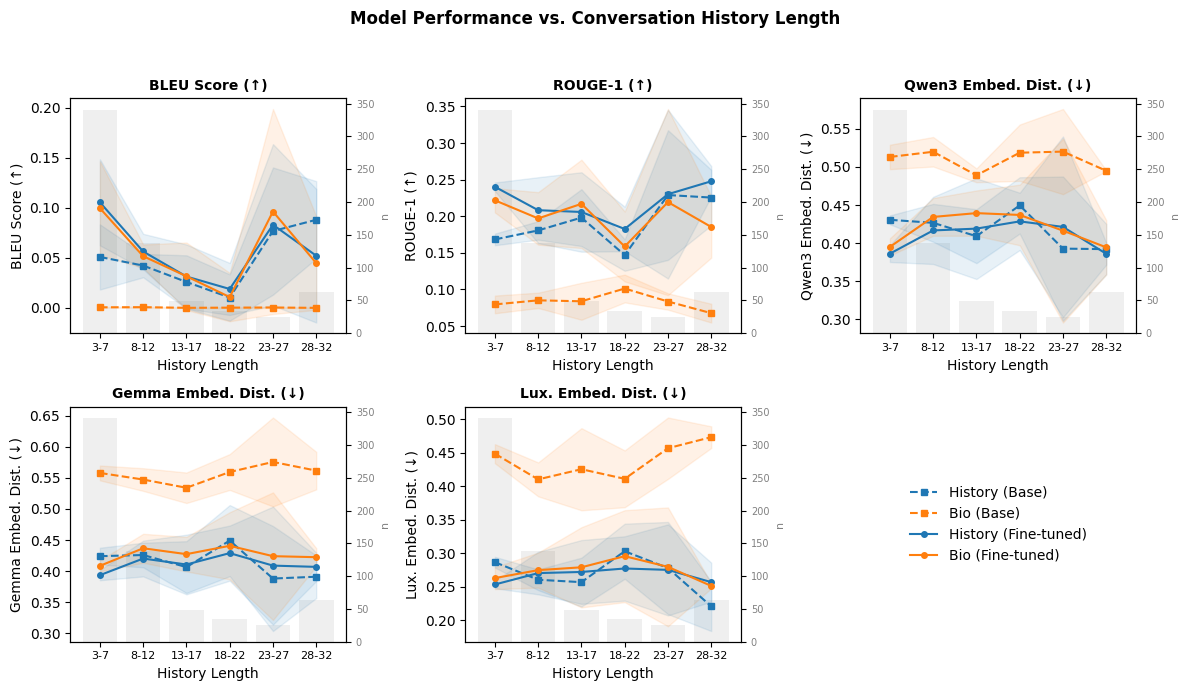

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metric_cols = ["bleu", "rouge1", "qwen3_embedding_distance", "gemma_embedding_distance", "luxembourgish_embedding_distance"]

metric_labels = {
    "bleu": "BLEU Score (↑)",
    "rouge1": "ROUGE-1 (↑)", 
    "qwen3_embedding_distance": "Qwen3 Embed. Dist. (↓)",
    "gemma_embedding_distance": "Gemma Embed. Dist. (↓)",
    "luxembourgish_embedding_distance": "Lux. Embed. Dist. (↓)"
}

legend_labels = {
    "history_base_model": "History (Base)",
    "bio_base_model": "Bio (Base)",
    "history_ft_model": "History (Fine-tuned)",
    "bio_ft_model": "Bio (Fine-tuned)"
}

# Switched: domain -> color, mode -> linestyle
colors = {"history": "tab:blue", "bio": "tab:orange"}
linestyles = {"base": "--", "ft": "-"}
markers = {"base": "s", "ft": "o"}  # Optional: square for base, circle for ft

bins = list(range(3, 35, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

results_df["history_bin"] = pd.cut(
    results_df["history_length"], 
    bins=bins, 
    labels=labels, 
    right=False
)

agg_mean = {col: "mean" for col in metric_cols}
agg_mean["num_samples"] = "sum"
agg_std = {col: "std" for col in metric_cols}

results_mean = results_df.groupby(["model", "history_bin"], observed=True).agg(agg_mean).reset_index()
results_std = results_df.groupby(["model", "history_bin"], observed=True).agg(agg_std).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

for idx, metric in enumerate(metric_cols):
    ax = axes[idx]
    
    ax2 = ax.twinx()
    sample_counts = results_mean[results_mean["model"] == model_names[0]].sort_values("history_bin")
    x_positions = np.arange(len(sample_counts))
    ax2.bar(
        x_positions, 
        sample_counts["num_samples"], 
        alpha=0.12, 
        color="gray", 
        width=0.8,
    )
    ax2.set_ylabel("n", color="gray", fontsize=8)
    ax2.tick_params(axis='y', labelcolor="gray", labelsize=7)
    ax2.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    for model_name in model_names:
        mode = "ft" if "ft" in model_name else "base"
        domain = "history" if "history" in model_name else "bio"
        
        subset_mean = results_mean[results_mean["model"] == model_name].sort_values("history_bin")
        subset_std = results_std[results_std["model"] == model_name].sort_values("history_bin")
        x_positions = np.arange(len(subset_mean))
        
        y_mean = subset_mean[metric].values
        y_std = subset_std[metric].values
        
        ax.fill_between(
            x_positions,
            y_mean - y_std,
            y_mean + y_std,
            color=colors[domain],
            alpha=0.10,
        )
        
        ax.plot(
            x_positions,
            y_mean,
            label=legend_labels[model_name],
            color=colors[domain],
            linestyle=linestyles[mode],
            marker=markers[mode],
            markersize=4,
            linewidth=1.5,
        )
    
    ax.set_xlabel("History Length")
    ax.set_ylabel(metric_labels[metric])
    ax.set_title(metric_labels[metric], fontsize=10, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sample_counts["history_bin"].values, rotation=0, fontsize=8)

# Shared legend in empty subplot
axes[5].axis("off")
handles, labels_leg = axes[0].get_legend_handles_labels()
axes[5].legend(handles, labels_leg, loc="center", fontsize=10, frameon=False)

for ax in axes[:5]:
    if ax.get_legend():
        ax.get_legend().remove()

fig.suptitle("Model Performance vs. Conversation History Length", fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig("../../reports/as1_metrics_vs_history_length.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

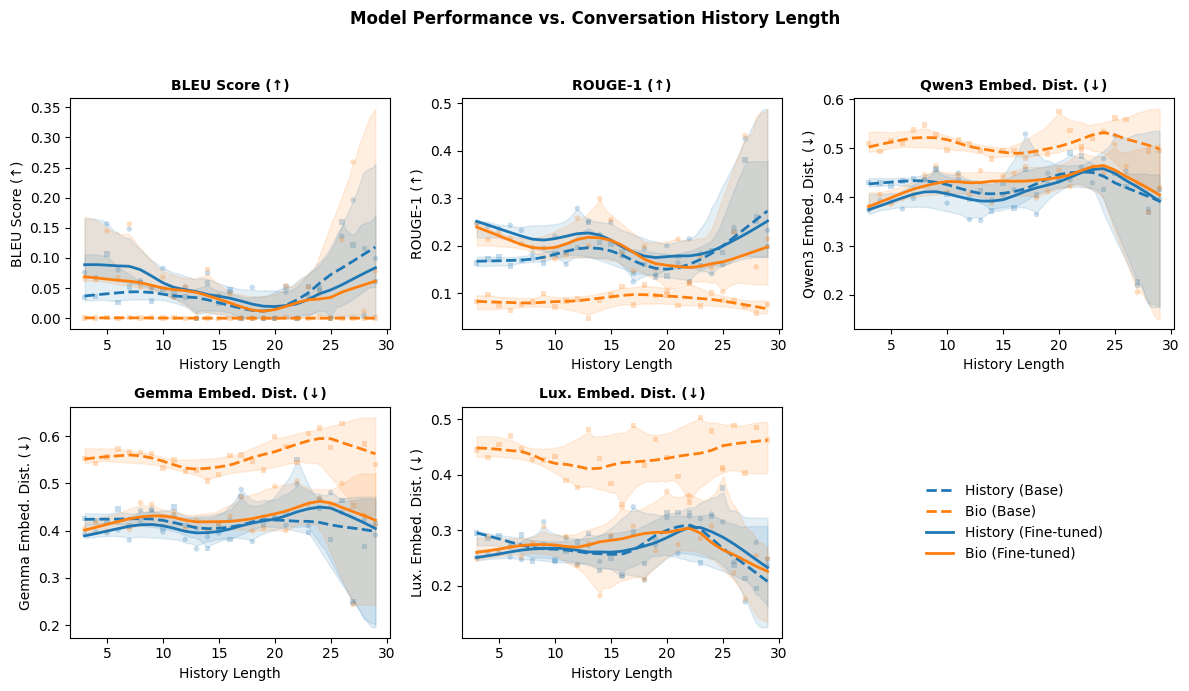

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

metric_cols = ["bleu", "rouge1", "qwen3_embedding_distance", "gemma_embedding_distance", "luxembourgish_embedding_distance"]

metric_labels = {
    "bleu": "BLEU Score (↑)",
    "rouge1": "ROUGE-1 (↑)", 
    "qwen3_embedding_distance": "Qwen3 Embed. Dist. (↓)",
    "gemma_embedding_distance": "Gemma Embed. Dist. (↓)",
    "luxembourgish_embedding_distance": "Lux. Embed. Dist. (↓)"
}

legend_labels = {
    "history_base_model": "History (Base)",
    "bio_base_model": "Bio (Base)",
    "history_ft_model": "History (Fine-tuned)",
    "bio_ft_model": "Bio (Fine-tuned)"
}

colors = {"history": "tab:blue", "bio": "tab:orange"}
linestyles = {"base": "--", "ft": "-"}
markers = {"base": "s", "ft": "o"}

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

for idx, metric in enumerate(metric_cols):
    ax = axes[idx]
    
    # Get global x range for consistent grid
    x_all = results_df["history_length"].values
    x_grid = np.linspace(x_all.min(), x_all.max(), 100)
    
    for model_name in model_names:
        mode = "ft" if "ft" in model_name else "base"
        domain = "history" if "history" in model_name else "bio"
        
        subset = results_df[results_df["model"] == model_name].sort_values("history_length")
        x = subset["history_length"].values
        y = subset[metric].values
        
        # Primary LOWESS fit
        lowess_result = sm.nonparametric.lowess(y, x, frac=0.4, return_sorted=True)
        x_smooth, y_smooth = lowess_result[:, 0], lowess_result[:, 1]
        
        # Interpolate to common grid
        y_main = np.interp(x_grid, x_smooth, y_smooth)
        
        # Bootstrap for CI
        np.random.seed(42)  # Reproducibility
        n_boot = 500
        y_boot = np.zeros((n_boot, len(x_grid)))
        
        for b in range(n_boot):
            # Resample with replacement
            idx_boot = np.random.choice(len(x), len(x), replace=True)
            x_b, y_b = x[idx_boot], y[idx_boot]
            
            # Sort for LOWESS
            sort_idx = np.argsort(x_b)
            x_b, y_b = x_b[sort_idx], y_b[sort_idx]
            
            try:
                lowess_b = sm.nonparametric.lowess(y_b, x_b, frac=0.4, return_sorted=True)
                y_boot[b] = np.interp(x_grid, lowess_b[:, 0], lowess_b[:, 1])
            except:
                y_boot[b] = np.nan
        
        # 95% CI
        ci_low = np.nanpercentile(y_boot, 2.5, axis=0)
        ci_high = np.nanpercentile(y_boot, 97.5, axis=0)
        
        # Plot CI band
        ax.fill_between(
            x_grid, ci_low, ci_high, 
            color=colors[domain], 
            alpha=0.12
        )
        
        # Plot smoothed line
        ax.plot(
            x_grid, y_main, 
            color=colors[domain], 
            linestyle=linestyles[mode],
            linewidth=2, 
            label=legend_labels[model_name]
        )
        
        # Raw data points (faint)
        ax.scatter(
            x, y, 
            color=colors[domain], 
            alpha=0.25, 
            s=15,
            marker=markers[mode],
            edgecolors='none'
        )
    
    ax.set_xlabel("History Length")
    ax.set_ylabel(metric_labels[metric])
    ax.set_title(metric_labels[metric], fontsize=10, fontweight='bold')

# Shared legend
axes[5].axis("off")
handles, labels_leg = axes[0].get_legend_handles_labels()
axes[5].legend(handles, labels_leg, loc="center", fontsize=10, frameon=False)

for ax in axes[:5]:
    if ax.get_legend():
        ax.get_legend().remove()

fig.suptitle("Model Performance vs. Conversation History Length", fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig("../../reports/as1_metrics_vs_history_length_lowess.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()